In [ ]:
import scipy.io
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KernelDensity
import scipy.ndimage
from tqdm import tqdm
from sklearn.metrics import silhouette_score


#import cv2
import warnings
warnings.filterwarnings("ignore")
mat = scipy.io.loadmat('/content/drive/MyDrive/Data_hoda_full.mat')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reframe date (zero padding)

In [ ]:
maX_1=0
maX_2=0
t=0
labels=[]
for i in range(4000):
    t=t+1
    labels.append(mat['labels'][i][0])
    if(len(mat['Data'][i][0]) > maX_1):
        maX_1=len(mat['Data'][i][0])
    if (len(mat['Data'][i][0][0]) > maX_2):
        maX_2 = len(mat['Data'][i][0][0])
#print(labels)
new_frame_data=[]
# Calculate the position to place the smaller array in the center
for i in range(4000):
    larger_matrix = np.zeros((maX_1, maX_2))
    row_start = (maX_1 - len(mat['Data'][i][0])) // 2
    col_start = (maX_2 - len(mat['Data'][i][0][0])) // 2
    small_rows, small_cols = mat['Data'][i][0].shape
    larger_matrix[row_start:row_start+small_rows, col_start:col_start+small_cols] = mat['Data'][i][0]
    new_frame_data.append(larger_matrix)

rows, cols = 5, 5

# Calculate the dimensions of each smaller zone
zone_height = 54 // rows
zone_width = 45 // cols

# Create a list of subarrays representing the zones\
data_after_zoning=[]
t=0
new_frame_data=np.array(new_frame_data)

<strong> extract needed features (zoning method)</strong>


In [ ]:
zone_rows = 54 // 5  # Divide into 5 rows
zone_cols = 45 // 5  # Divide into 5 columns

# Initialize the new 5x5 matrix
new_matrix = np.zeros((5, 5))
vectorized_zonal_mean_feature=[]
# Iterate over zones and calculate the average for each
for k in range(len(new_frame_data)):
    original_matrix=new_frame_data[k]
    new_matrix = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            zone = original_matrix[i * zone_rows:(i + 1) * zone_rows, j * zone_cols:(j + 1) * zone_cols]
            zone_average = np.mean(zone)
            new_matrix[i, j] = zone_average
    vectorized_array = new_matrix.ravel()
    vectorized_zonal_mean_feature.append(vectorized_array)
# new_matrix now contains the 5x5 matrix with the average values of each zone
vectorized_zonal_mean_feature=np.array(vectorized_zonal_mean_feature)

histogram_feature_set=[]
for i in range(4000):
    col_sums = np.sum(np.abs(new_frame_data[i]), axis=0)
    row_sums = np.sum(np.abs(new_frame_data[i]), axis=1)
    concatenated_array = np.concatenate((col_sums, row_sums), axis=0)
    histogram_feature_set.append(concatenated_array)

X_train_zoning=vectorized_zonal_mean_feature[:3000]
y_train=labels[:3000]
X_test_zoning=vectorized_zonal_mean_feature[3000:]
y_test=labels[3000:]

<strong>Functions used in kmeans clustering</strong>


In [ ]:
#######################
###k-means functions
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

         # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        #print(index)
        #print((index[0][0]))
        # append actual labels for each point in cluster
        #print(actual_labels[index[0]])
        for j in range(len(index[0])):
            labels.append(actual_labels[index[0][j]])
        #labels.append(actual_labels[index[0]])
        #print(len(labels))
        #print(labels)
        # determine most common label
        if len(labels) == 1:
            counts = np.bincount(labels)
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]


    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels
def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

<strong>Calculate silhouette score the find the optimum number of</strong>


Accuracy of k-means using zonal features: 0.84
[0.16601430641041176, 0.15812174765390158, 0.15082745338802775, 0.14742492520794323, 0.1400746808825909, 0.13563237005214407, 0.13430519472096764, 0.13596738933430041, 0.12832823700115034, 0.1334245717710582, 0.1261805112126366, 0.12597556899248047, 0.1237458546769628, 0.1124279873643488, 0.11655048732666315, 0.12683827831115035, 0.12038797830304641, 0.11540888271946055, 0.11545534383512135, 0.11992660027436307, 0.11364716394373901, 0.11730044078127393, 0.1150089107785703, 0.10993228047921104, 0.11070198528094435, 0.10781013711467688, 0.11374125158326531, 0.10602250376371782, 0.11597984101980054, 0.11172817216424998]


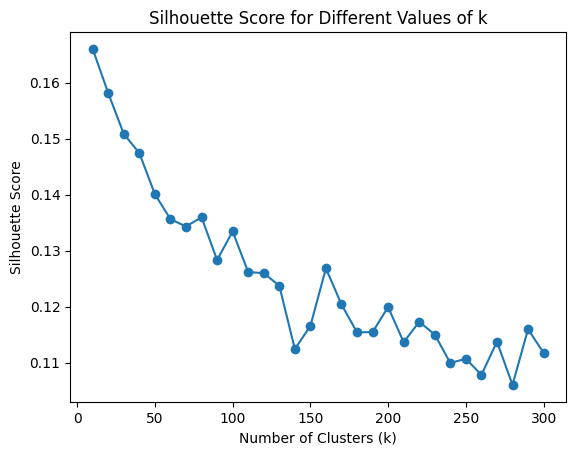

In [ ]:

s = []
k = []
for i in range (30):
  n = 10 * ( i + 1 )
  k.append(n)
# initialize and fit KMeans algorithm on training data
  kmeans = MiniBatchKMeans(n_clusters = n)
  kmeans.fit(X_train_zoning)
  labels = kmeans.labels_
  s.append( silhouette_score(X_train_zoning, labels))


plt.plot(k, s, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Silhouette Score for Different Values of k')
plt.show()


<strong>Perform kmeans using the optimum k</strong>


In [ ]:
  kmeans = MiniBatchKMeans(n_clusters = 256)
  kmeans.fit(X_train_zoning)
  centers = kmeans.cluster_centers_


<strong>Functions needed to train rbf network</strong>


In [ ]:


def gaussian_rbf(x, c, s):
    return np.exp(-1 / (2 * s**2) * np.linalg.norm(x - c)**2)

def gaussian_rbf_matrix(X, C, s):
    # X: Matrix of input samples (shape: m x n)
    # C: Matrix of centers (shape: k x n)
    # s: Width or scale parameter of the Gaussian RBF kernel

    # Calculate pairwise Euclidean distances between all samples and centers
    distances = np.linalg.norm(X[:, np.newaxis, :] - C, axis=2)

    # Calculate Gaussian RBF kernel matrix
    rbf_matrix = np.exp(-1 / (2 * s**2) * distances**2)

    return rbf_matrix


def calculate_hidden_output(input_data, centers, sigmas, weights):
    # Calculate the RBF activations
    rbf_activations = np.array([gaussian_rbf(input_data, c, s) for c, s in zip(centers, sigmas)])

    # Calculate the output of the RBF network
    output = softmax(np.dot(rbf_activations, weights))


    return output

def calculate_output(hidden_layer_output, weights):
    result = np.dot(weights, hidden_layer_output)
    return result

def train_section(k,learningRate,X_train,centers,n_epochs,number_output):
          number_hidden_layer = k
          learning_rate = learning_rate
          np.random.seed(42)
          X_new = calculate_rbf_activations(X_train_zoning,centers, 1000)
          weights_hidden_output = np.random.rand(k,10)
          bias_output = np.random.rand(1,10)
          for i in tqdm(range(n_epochs)):
              # Back propagation
              for j in range(3000):
                  output = X_new @ weights_hidden_output+bias_output
                  d_w = 0
                  d_b = 0
                  y = get_y( y_train[j])
                  d_w = learning_rate*X_new[j].T.reshape(k,1)@(y-output[j])
                  d_b = learning_rate*(y-output[j])
                  weights_hidden_output += d_w
                  bias_output += d_b
          return weights_hidden_output, bias_output
def test_section(weights, bias, X_test, centers, sigma, y_test):
    X_test_final  = calculate_rbf_activations(X_test,centers,1000)
    input = X_test_final @ weights + bias
    prob = softmax(input)
    acc = give_accuracy(y_test, prob)
    return acc

def calculate_rbf_activations(data, centers, sigma):
    activations = np.zeros((data.shape[0], len(centers)))
    for i in range(len(centers)):
        x = np.exp(-np.sum((data - centers[i])**2/(2*sigma), axis=1))
        activations[:, i] = x
    return activations

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    x = x*3
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def get_y(label):
    y = np.zeros((1,10))
    y[0, label] = 1
    return y

def give_accuracy(y_test, predicted):
    l = len(y_test)
    count = 0
    for i in range(l):
        x1 = y_test[i]
        x2 = np.argmax(predicted[i,:])
        if x1 == x2:
            count += 1
    return count/l
def calculate_error(y, predicted_output):
  temp = []
  for i in range (len(y)):
    temp.append(y[i] - predicted_output)
  return np.array(temp)


**Train and Test Phase**

In [ ]:
weights, bias = train_section(256,0.01,X_train_zoning,centers,300,10)
accuracy = test_section(weights, bias, X_test_zoning, centers, 1000, y_test)

In [ ]:
print(accuracy)

0.78
